In [7]:
import networkx as nx
import cdlib
from tqdm import tqdm
import umap
import sklearn, itertools, random
import pandas as pd
from sklearn.neighbors import kneighbors_graph
from sklearn.decomposition import PCA
import scipy as sp
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import numpy as np
import igraph as ig
from sklearn.utils import shuffle
import scipy
import leidenalg
import math
from sklearn.metrics import adjusted_mutual_info_score

df_1 = pd.read_csv('ReTranscriptomics.csv')
print(df_1.shape)
df_2 = pd.read_csv('ReProteomics.csv')
df_1 = df_1.iloc[df_1[df_1['BH Adj P-Value'] <= 0.01].index.tolist(),:]
df_2 = df_2.iloc[df_2[df_2['BH Adj P-Value'] <= 0.01].index.tolist(),:]

df_c = pd.concat([df_1, df_2])
df_c = df_c.reset_index().drop(columns = 'index')


df_c = df_c[df_c['Period'] >= 12]
df_c = df_c[df_c['Period'] <= 36]
ids = df_c['Gene Name'].values
df_c.shape

df = df_c.iloc[:,df_c.columns.str.startswith('Fitted')]
df.shape

(36452, 112)


(12078, 24)

In [8]:
from sklearn.cluster import SpectralClustering
corr = np.corrcoef(df)
spc = SpectralClustering(n_clusters = 30, random_state = 1, affinity = 'precomputed', n_jobs = -1)
mat = np.power(corr,3)
    
X_std = (mat - mat.min()) / (mat.max() - mat.min())
    
X_sc = X_std * (1-0) + 0
spc_model = spc.fit(X_sc)
        
spc_labels = spc_model.labels_
                

In [9]:
ccc = ['Nr1d1', 'Nr1d2', 'Cry1', 'Cry2', 'Per1', 'Per2', 'Ciart', 'Dbp', 'Tef', 'Npas2', 'Ifit3', 'Ifit1', 'Ifit2', 'Oas2']
cc_i = [np.where(ids == ccc[i])[0][0] for i in range(len(ccc))]
cc_i

spc_labels[cc_i]

array([11, 11, 25, 11, 11, 13, 11, 11, 11, 17, 11, 11, 11, 11],
      dtype=int32)

In [10]:
def GaussianNoiseGenerator(noise, data, r):
    if len(data.shape) == 1:
        n_rows = len(data)
        n_cols = 1
        NoiseLayer = np.empty((n_rows))
    else:
        n_rows, n_cols = data.shape
        NoiseLayer = np.empty((n_rows, n_cols))
    
    if noise == 0:
        return data
    
    for i in range(n_cols):
        np.random.seed(r*i)
        scale = noise*np.std(data[:,i])
        if len(NoiseLayer.shape) == 1:
            NoiseLayer = np.random.normal(loc = 0, scale = scale, size = n_rows)
        else:
            NoiseLayer[:,i] = np.random.normal(loc = 0, scale = scale, size = n_rows)
        NoiseLayer[:,i] = shuffle(NoiseLayer[:,i], random_state = r*i)
            
    NoisyData = np.copy(data) + NoiseLayer
        
    return NoisyData

x = np.array(df)
num_iter = 50
noise_levels = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
ari_spc = []
 
for j in range(len(noise_levels)):
    n_ = noise_levels[j]
    temp = np.zeros((50,))
    for k in tqdm(range(num_iter)):
        N = GaussianNoiseGenerator(noise = n_, data = x, r = k*j)
        NC = np.corrcoef(N)
            
        spc = SpectralClustering(n_clusters = 30, random_state = 1, affinity = 'precomputed', n_jobs = -1)        
        mat = np.power(NC,3)
    
        X_std = (mat - mat.min()) / (mat.max() - mat.min())
    
        X_sc = X_std * (1-0) + 0
        spc_model = spc.fit(X_sc)
        
        spc_pert = spc_model.labels_
                
        temp[k] = adjusted_mutual_info_score(spc_pert, spc_labels)

            
    ari_spc.append(np.mean(temp))

        

        


100%|██████████| 50/50 [27:54<00:00, 33.48s/it]


In [11]:
ari_spc

[0.8084852098575638,
 0.7403446007942174,
 0.7214372748693425,
 0.6997191784874143,
 0.6700539068394451,
 0.6387686259696274,
 0.6093288009701755,
 0.5793476343112645,
 0.5556484731686921,
 0.5331116800589182]

In [12]:
noise_levels

[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

<BarContainer object of 10 artists>

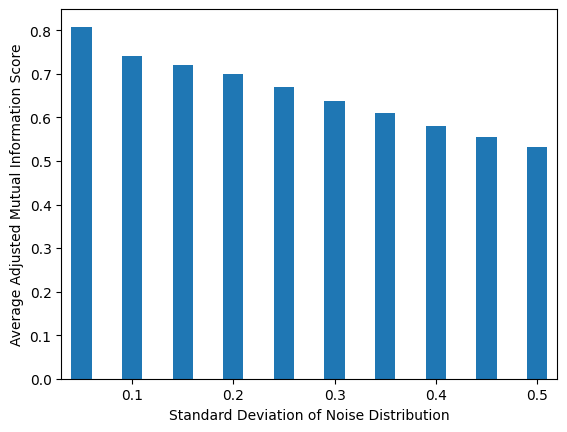

In [13]:
x_axis = np.arange(10)
plt.xlim([0.03,0.52])
plt.ylabel('Average Adjusted Mutual Information Score')
plt.xlabel('Standard Deviation of Noise Distribution')
#plt.xticks(['0','0.05','0.1','0.15','0.2','0.25','0.3','0.35','0.4','0.45','0.5'])
plt.bar(noise_levels, ari_spc, width = 0.02)